# Requirement on antenna pattern
## SCI-MIS-0250: Knowledge of the antenna pattern in amplitude
The susceptibility of the observatory to the strain of a GW shall be known to better than 10−4 in amplitude for any polarisation of the GW, at any given time during the mission lifetime, and for any given position of the GW source in the sky.
## SCI-MIS-0260: Knowledge of the antenna pattern in phase
The susceptibility of the observatory to the strain of a GW shall be known to better than 10−2 rad in phase for any polarisation of the GW, at any given time during the mission lifetime, and for any given position of the GW source in the sky.
## Rationale: 
Many science objectives and science investigations depend on the knowledge of the strain of the gravitational wave signal that needs to be calculated from the measured signal with sufficient accuracy. Requiring the which is given by this requirement. In the flow-down, this sets requirements on spacecraft (S/C) position knowledge, knowledge of the laser wavelength, precision of the reconstruction etc.

3D orbit plot saved to 3d_orbit_around_sun.png


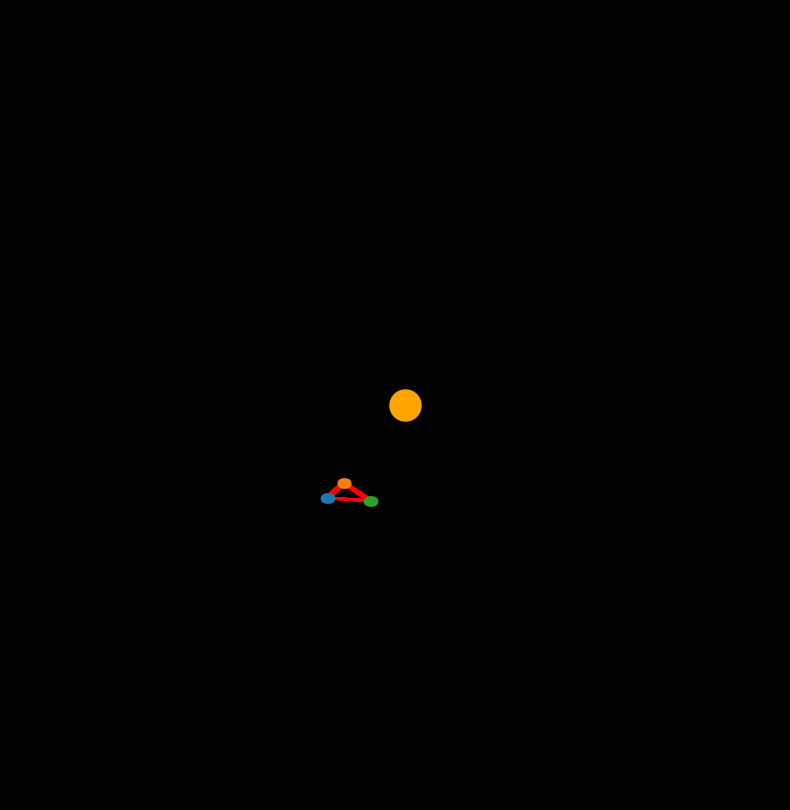

In [49]:
# run with python as
# nohup python assess_impact.py > out.out &
import os, sys

# Get CUDA device and frequency of GB binary from command-line arguments
cuda_device = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import sawtooth
from scipy.signal.windows import tukey
import h5py
from fastlisaresponse import pyResponseTDI, ResponseWrapper
from astropy import units as un
from lisatools.utils.constants import *
# make nice plots
np.random.seed(2601)

from utils import *

fpath = "new_orbits.h5"
T = 1.0/365  # years
plot_orbit_3d(fpath, T)
plt.show()

In [50]:
psd = np.load("../EMRI-FoM/pipeline/TDI2_AE_psd.npy")
# interpolate the psd with a cubic spline
from scipy.interpolate import CubicSpline
psd_interp = CubicSpline(psd[:, 0], psd[:, 1])


In [65]:
use_gpu = True
dt = 0.5
gb = GBWave(use_gpu=use_gpu, T=T, dt=dt)

def get_response(orbit):
    # default settings
    # order of the langrangian interpolation
    order = 25
    # 1st or 2nd or custom (see docs for custom)
    tdi_gen = "2nd generation"
    index_lambda = 6
    index_beta = 7
    t0 = 10000.0  # time at which signal starts (chops off data at start of waveform where information is not correct)
    tdi_kwargs_esa = dict(order=order, tdi=tdi_gen, tdi_chan="AET",)
    return ResponseWrapper(
    gb,
    T,
    dt,
    index_lambda,
    index_beta,
    t0=t0,
    flip_hx=False,  # set to True if waveform is h+ - ihx
    use_gpu=use_gpu,
    remove_sky_coords=True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude=True,  # False if using polar angle (theta)
    remove_garbage=True,  # removes the beginning of the signal that has bad information
    orbits=orbit,
    **tdi_kwargs_esa,
    )

def get_variation(time_vec, t_initial=0, period=14*86400, rho=1.0):
    """
    Generate a periodic variation in the local orbital frame
    :param time_vec: time vector
    :param t_initial: initial time
    :param period: period of the variation
    :param rho: amplitude of the variation
    :return: 2D array of shape (len(time_vec), 3)
    """
    size = len(time_vec)
    periodic = sawtooth(2 * np.pi * (time_vec-t_initial)/period)
    # res =  random_vectors_on_sphere(size=size)[0] * rho * (1 + periodic[:,None])/2
    periodic = (1-np.cos(2 * np.pi * (time_vec-t_initial)/period)) / 2
    res =  random_vectors_on_sphere(size=size)[0] * rho * periodic[:,None]
    # fixed random
    res = np.ones_like(random_vectors_on_sphere(size=size)) * random_vectors_on_sphere(size=size)[0] * rho
    # random
    res = random_vectors_on_sphere(size=size) * rho
    return res
    
    
def compute_inn_and_den(fft_def, fft_dev, psd_, mask_sum, df):
    """
    Compute the inn and den quantities for FFT-based analysis.

    :param fft_def: FFT of the default signal
    :param fft_dev: FFT of the deviated signal
    :param psd_: Power Spectral Density (PSD) values
    :param mask_sum: Mask for the frequency range of interest
    :param df: Frequency resolution
    :return: Tuple containing inn and den values
    """
    d_h = 4 * xp.sum(fft_def[mask_sum].conj() * fft_dev[mask_sum] / psd_).real * df
    d_d = 4 * xp.sum(fft_dev[mask_sum].conj() * fft_dev[mask_sum] / psd_).real * df
    h_h = 4 * xp.sum(fft_def[mask_sum].conj() * fft_def[mask_sum] / psd_).real * df
    A_est = d_h / h_h
    tan_phi_est = 4 * xp.sum(fft_def[mask_sum].conj() * fft_dev[mask_sum] / psd_).imag * df / d_h
    Im = xp.sum(fft_def[mask_sum].conj() * fft_dev[mask_sum] / psd_).imag * df
    Re = d_h 
    tan_phi_est = Im / Re
    phi_est = np.arctan(tan_phi_est)
    print("estimated A and phi",A_est, phi_est)
    loglike_diff = 4 * xp.sum(xp.abs(fft_def[mask_sum] - fft_dev[mask_sum])**2 / psd_).real * df
    # print(loglike_diff, d_d + h_h -2*d_h)
    mismatch = xp.abs(1 - d_h / xp.sqrt(h_h * d_d))
    return A_est, phi_est, mismatch


In [66]:
# Create orbit objects
fpath = "new_orbits.h5"
orb_default = ESAOrbits(fpath,use_gpu=use_gpu)
deviation = {which: np.zeros_like(getattr(orb_default, which + "_base")) for which in ["ltt", "x", "n", "v"]}
orb_default.configure(linear_interp_setup=True, deviation=deviation)
# default orbit
gb_lisa_esa = get_response(orb_default)

# define variations
# fig 72 of ESA-LISA-ESOC-MAS-RP-0001 Iss2Rev0 - LISA Consolidated Report on Mission Analysis.pdf
# division by 3 because of the three sigma and multiply by 1e3 to convert to meters
# radial
sig_ref = 1e3
sigma_radial = sig_ref * 1e3 /3 #50e3
# along-track
sigma_along = sig_ref * 1e3 /3#10e3
# cross-track
sigma_cross =  sig_ref * 1e3 /3#100e3
list_sigma = [sigma_radial, sigma_along, sigma_cross]

change = "x"
sigma_vec = [1, 10, 100, 1000]
orbit_list = []

for delta_x in sigma_vec:
    # create the deviation dictionary
    orb_dev = ESAOrbits(fpath,use_gpu=use_gpu)
    deviation = {which: np.zeros_like(getattr(orb_dev, which + "_base")) for which in ["ltt", "x", "n", "v"]}
    
    # time
    time_vec = orb_dev.t_base
    size = len(orb_dev.t_base)
    xbase = orb_dev.x_base
    local_orbital_frame_pos = np.sum(xbase,axis=1)/3
    
    # loop over spacecraft
    for sc in range(3):
        # deviation in the local orbital frame
        deviation_lof = get_variation(time_vec, t_initial=0, period=14*86400, rho=delta_x * list_sigma[0])
        deviation["x"][:, sc, :] += deviation_lof
        deviation["v"][:, sc, :] += np.gradient(deviation_lof,time_vec, axis=0)

    orb_dev.configure(linear_interp_setup=True, deviation=deviation)
    orbit_list.append(orb_dev)


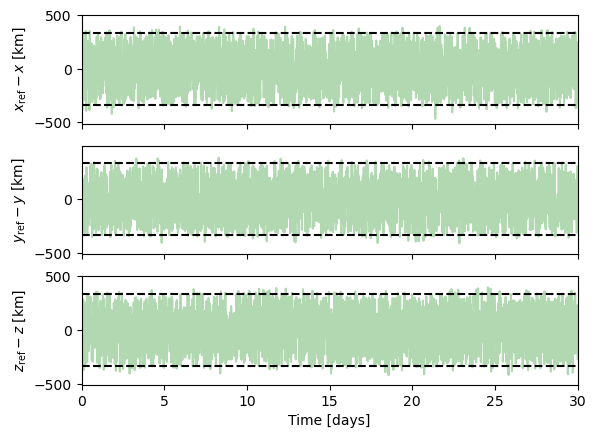

In [67]:
coord_color = [(r"$x_{\rm ref} - x$ [km]", "g"), (r"$y_{\rm ref} - y$ [km]","b"), (r"$z_{\rm ref}- z$ [km]","r")]
fig, ax = plt.subplots(3, 1, sharex=True)
for orb_dev in orbit_list[:1]:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    for ii in range(3):
        for sc in range(1):
            ax[ii].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, 
                        (arr_def[:, sc, ii]-arr[:, sc, ii])/1e3, 
                        label=f"SC{sc}",color=coord_color[sc][1], alpha=0.3)
            
        ax[ii].axhline(list_sigma[ii]/1e3, linestyle='--', color='k')
        ax[ii].axhline(-list_sigma[ii]/1e3, linestyle='--', color='k')
        ax[ii].set_ylabel(coord_color[ii][0])
        # ax[ii].set_xlim(0, 30)
        

    ax[2].set_xlabel("Time [days]")
plt.xlim([0.0, 30])
plt.savefig("orbits_deviation.png")


(105119,) (105119,)
(105119,) (105119,)
(105119,) (105119,)


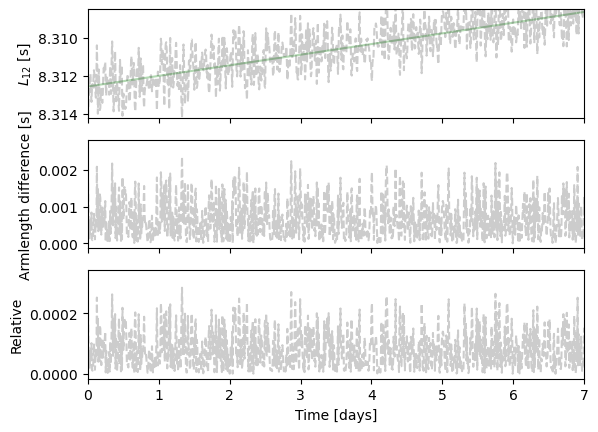

In [68]:
coord_color = [("$L_{12}$ [s]", "g")]
fig, ax = plt.subplots(3, 1, sharex=True)
for orb_dev in orbit_list[:1]:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    ii = 0
    deviation = np.linalg.norm(arr_def[:, ii]-arr_def[:, ii+1],axis=1)/C_SI
    ax[ii].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, 
                deviation, 
                color=coord_color[sc][1], alpha=0.3)
    
    ref = np.linalg.norm(arr[:, ii]-arr[:, ii+1],axis=1)/C_SI
    print(ref.shape, deviation.shape)
    ax[ii].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, ref, linestyle='--', color='k',alpha=0.2)
    ax[ii].set_ylabel(coord_color[ii][0])
    ax[ii].set_ylim([ref[0].min(), ref[1000].max()])
        
for orb_dev in orbit_list[:1]:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    ii = 0
    deviation = np.linalg.norm(arr_def[:, ii]-arr_def[:, ii+1],axis=1)/C_SI
    ref = np.linalg.norm(arr[:, ii]-arr[:, ii+1],axis=1)/C_SI
    diff = np.abs(ref-deviation)
    print(ref.shape, deviation.shape)
    ax[1].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, diff, linestyle='--', color='k',alpha=0.2)
    ax[1].set_ylabel("Armlength difference [s]")


for orb_dev in orbit_list[:1]:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    ii = 0
    deviation = np.linalg.norm(arr_def[:, ii]-arr_def[:, ii+1],axis=1)/C_SI
    ref = np.linalg.norm(arr[:, ii]-arr[:, ii+1],axis=1)/C_SI
    diff = np.abs(ref-deviation)/ref
    print(ref.shape, deviation.shape)
    ax[2].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, diff, linestyle='--', color='k',alpha=0.2)
    ax[2].set_ylabel("Relative")

ax[2].set_xlabel("Time [days]")
plt.xlim([0.0, 7])
plt.savefig("armlength_deviation.png")


Text(0, 0.5, 'Deviation Radius [km]')

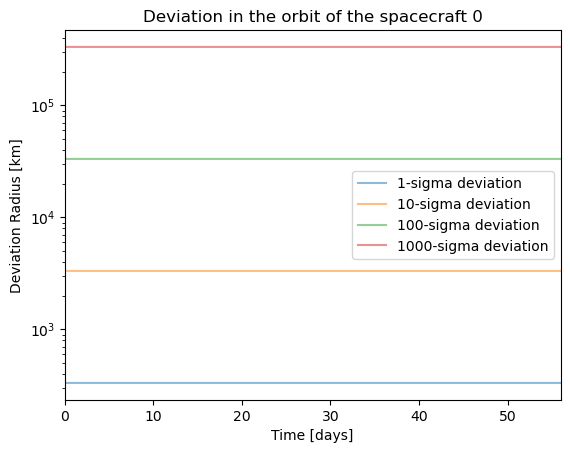

In [69]:
plt.figure()
sc = 0
plt.title(f"Deviation in the orbit of the spacecraft {sc}")
for delta_x, orb_dev in zip(sigma_vec, orbit_list):
    # plot the deviation
    time_vec = orb_dev.t_base
    deviation_lof = orb_dev.deviation["x"][:, sc, :]
    # plot deviation
    # print(delta_x, np.diff(np.linalg.norm(deviation_lof,axis=1))/1e3 )

    plt.semilogy(time_vec/86400, np.linalg.norm(deviation_lof,axis=1)/1e3 ,label=f"{int(delta_x)}-sigma deviation", alpha=0.5)
plt.xlim([0.0, 14*4])
# plt.ylim([0.5, 4e4])
plt.xlabel("Time [days]")
plt.legend()
plt.ylabel("Deviation Radius [km]")

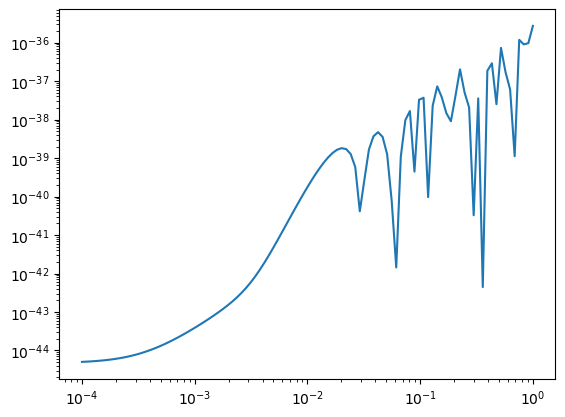

In [103]:
plt.figure()
ff = np.logspace(-4, 0.0, 100)
plt.loglog(ff,psd_interp(ff))

In [ ]:
# define GB default parameters
A = 1e-15
gb_frequency = np.logspace(-4, 0.0, 100)
fdot = 1.5e-17
sigma_ind = 0
sigma_vec = [1, 10, 100, 1000]
print("sigma_ind", sigma_ind, "sigma", sigma_vec[sigma_ind])
# import and interpolate psd ../EMRI-FoM/pipeline/TDI2_AE_psd.npy

# decie how many variations
channel_generator = [get_response(orb_dev) for orb_dev in orbit_list]

# randomly draw the sky coordinates
Ndraws = 50
par_list = np.asarray([draw_parameters(A=A, f=1e-3, fdot=fdot) for i in range(Ndraws)])
# dict of results per each frequency
result_dict = {f: [] for f in gb_frequency}

for f in gb_frequency:
    par_list[:,1] = f
    print("Frequency", f, par_list[:,1])

    for realization in range(Ndraws):
        
        print(realization, par_list[realization])
        # print("Generating channels")
        chans = [channel_generator[i](*par_list[realization]) for i in range(len(channel_generator))]
        chans_default = gb_lisa_esa(*par_list[realization])
        # print("Channels generated")

        # Save deviations for each delta_x
        delta_x, chan = sigma_vec[sigma_ind], chans[sigma_ind]

        for i, lab in enumerate(["A"]):

            tukey_window = xp.asarray(tukey(len(chan[i]), alpha=0.5))
            fft_f = xp.fft.rfftfreq(len(chan[i]), dt)
            df = fft_f[1] - fft_f[0]
            mask_sum = (fft_f > f-1000*df) & (fft_f < f+1000*df)
            # mask_sum = (fft_f > 5e-5) & (fft_f < 1.0)
            fft_def = xp.fft.rfft(chans_default[i]*tukey_window,axis=1)*dt
            fft_dev = xp.fft.rfft(chan[i]*tukey_window,axis=1)*dt
            
            psd_ = xp.asarray(psd_interp(fft_f[mask_sum].get()))
            df = fft_f[1] - fft_f[0]

            A_est, phi_est, mismatch = compute_inn_and_den(fft_def, fft_dev, psd_, mask_sum, df)
            # result_dict[f] += [ [np.abs(1-A_est.get()), np.abs(phi_est.get()), np.abs(mismatch.get())] ]


sigma_ind 0 sigma 1
Frequency 0.0001 [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
0 [1.00000000e-15 1.00000000e-04 1.50000000e-17 2.03331713e+00
 3.66505499e+00 7.55700810e-02 4.11234382e-02 5.16642079e+00]
estimated A and phi 1.000007574761414 3.4638542269460625e-08
1 [1.00000000e-15 1.00000000e-04 1.50000000e-17 1.99551223e+00
 2.67263330e-01 4.33393338e+00 6.99768503e-03 5.83861351e-01]
estimated A and phi 0.9999369045335732 -6.611173707311522e-06
2 [1.00000000e-15 1.00000000e-04 1.50000000e-17 1.31988526e+00
 1.09390577e-01 4.21399944e+00 9.19299364e-01 4.35433166e+00]
estimated A and phi 1.0000269598313 3.6917783582332327e-06
3 [1.00000000e-15 1.00000000e-04 1.50000000e-17 1.

In [ ]:
import json
# with open(f"all_freq_results.json", "w") as json_file:
#     json.dump(result_dict, json_file)

with open(f"all_freq_results.json", "r") as json_file:
    result_dict = json.load(json_file)

# result_dict.keys()

dict_keys(['0.0001', '0.00010974987654930556', '0.00012045035402587823', '0.00013219411484660288', '0.000145082877849594', '0.00015922827933410923', '0.0001747528400007683', '0.00019179102616724886', '0.00021049041445120198', '0.00023101297000831605', '0.00025353644939701115', '0.0002782559402207126', '0.0003053855508833416', '0.0003351602650938841', '0.0003678379771828634', '0.0004037017258596554', '0.0004430621457583882', '0.00048626015800653534', '0.0005336699231206312', '0.0005857020818056667', '0.0006428073117284319', '0.0007054802310718645', '0.000774263682681127', '0.0008497534359086447', '0.0009326033468832199', '0.001023531021899027', '0.0011233240329780276', '0.0012328467394420659', '0.0013530477745798076', '0.001484968262254465', '0.0016297508346206436', '0.001788649529057435', '0.0019630406500402726', '0.0021544346900318843', '0.002364489412645407', '0.002595024211399737', '0.002848035868435802', '0.0031257158496882354', '0.003430469286314919', '0.0037649358067924714', '0.0

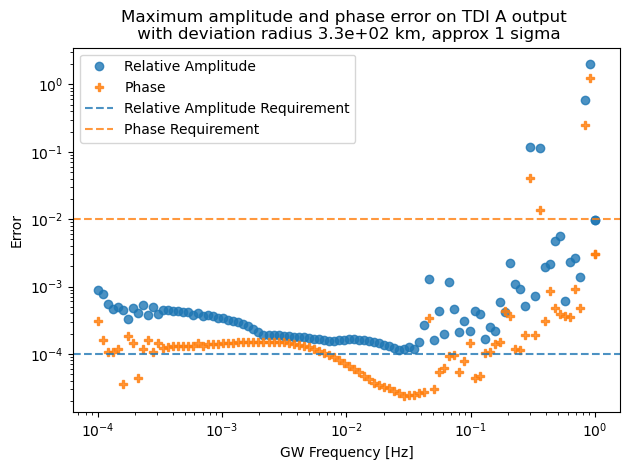

In [115]:
plt.figure()
for f in gb_frequency:
    res_list = np.asarray(result_dict[str(f)])
    res_median = np.quantile(res_list, 0.5, axis=0)
    res_error = np.std(res_list, axis=0)
    # max and min
    res_max = np.max(res_list, axis=0)
    res_min = np.min(res_list, axis=0)

    # plot difference amplitude with error bars
    # plt.errorbar(f, res_median[0], yerr=res_error[0], fmt="o", alpha=0.8, color="C0")#, label="Relative Amplitude")
    
    # plot phase with error bars
    # plt.errorbar(f, res_median[1], yerr=res_error[1], fmt="P", alpha=0.8, color="C1")#, label="Phase")

    plt.plot(f, res_max[0], "o", alpha=0.8, color="C0")#, label="Relative Amplitude")
    plt.plot(f, res_max[1], "P", alpha=0.8, color="C1")#, label="Phase")

    # plt.loglog(fft_f[mask_sum].get(), xp.abs(fft_def[mask_sum] - fft_dev[mask_sum]).get()**2, label=f"GW f={f:.1e} Hz, Mism={mismatch:.1}", alpha=0.5)
    # plt.axvline(x=f, linestyle="--", label=f"Signal frequency {f:.1e} Hz")
    # plt.loglog(fft_f[mask_sum].get(), xp.abs(fft_def[mask_sum]).get()**2, label="def", alpha=0.5)
    # plt.loglog(fft_f[mask_sum].get(), xp.abs(fft_dev[mask_sum]).get()**2, label="dev", alpha=0.5)

plt.plot(f, res_max[0], "o", alpha=0.8, color="C0", label="Relative Amplitude")
plt.plot(f, res_max[1], "P", alpha=0.8, color="C1", label="Phase")

# plot difference amplitude
# plt.loglog(f, np.abs(1-res_list)[0], "o", label="Relative Amplitude", alpha=0.8, color="C0")
plt.axhline(y=1e-4, linestyle="--", color="C0", alpha=0.8, label="Relative Amplitude Requirement")
# phase
# plt.loglog(f, np.abs(res_list)[1], "P", label="Phase", alpha=0.8, color="C1")
plt.xscale("log")
plt.yscale("log")
plt.axhline(y=1e-2, linestyle="--", color="C1", alpha=0.8, label="Phase Requirement")
plt.xlabel("GW Frequency [Hz]")

plt.ylabel(r"Error")
# plt.ylabel(r"$|\tilde h_{\rm ref}-\tilde h|^2$")
plt.title(f"Maximum amplitude and phase error on TDI {lab} output \n with deviation radius {delta_x * list_sigma[sigma_ind]/1e3:.1e} km, approx {int(delta_x)} sigma")
# plt.loglog(fft_f[mask_sum].get(), psd_.get(), color='k', label="psd", alpha=0.8, linestyle="--")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(f"assessment_{lab}_deviation_radius_{delta_x * list_sigma[sigma_ind]/1e3:.1e}km.png",dpi=300)
plt.show()
